## Ansatze and variational forms

At the heart of all [variational algorithms](variational.ipynb) is the key idea of analyzing the differences between states; conveniently related through some well behaved mapping (e.g. continuous, differentiable) from a set of parameters or _variables_ —hence the name.

In quantum computing, these algorithms work by exploring and comparing a range of _quantum states_ $|\psi(\vec{\theta})\rangle$, depending on a (finite) set of $k$ parameters $\vec{\theta} = (\theta^0,...,\theta^{k-1})$. These states can in turn be prepared through a _parametrized_ quantum circuit, representing certain parametric unitary transformation $U_V(\vec{\theta})$ from the [reference state](reference.ipynb), formally referred to as a _variational form_:

$$
|0\rangle \xrightarrow{U_R} 
U_R|0\rangle = |\rho\rangle \xrightarrow{U_V(\vec{\theta})} 
U_A(\vec{\theta})|0\rangle = 
U_V(\vec{\theta})U_R|0\rangle = 
U_V(\vec{\theta})|\rho\rangle = 
|\psi(\vec{\theta})\rangle
$$

Notice that the parametrized state, depends both on the reference state $|\rho\rangle$ (i.e. its associated unitary $U_R$), which does not depend on any parameters (i.e. if existent they are fixed); as well as on the variational form $U_V(\vec{\theta})$, which always depends on parameters. The combination of these two halves will be formally referred to as an _ansatz_, from the German word for "approach" or "attempt", although some references use the terms _ansatz_ and _variational form_ interchangeably: $U_A(\vec\theta) := U_V(\vec\theta)U_R$. Quantum circuits carrying out certain ansatze are oftentimes referred to as _ansatz circuits_.

A commonly encountered shortcoming, is the fact that the amount of distinct quantum states in the configuration space of an $n$-qubit system (i.e. _Hilbert space_) is so vast that we would require an unwieldy large number of parameters to fully explore it. Quantitatively, its dimensionality is $D = 2^{2n}$. To make matters worse, the runtime complexity of search algorithms —and others alike— grows exponentially with this dimensionality, a phenomenon often referred to in the literature as the _curse of dimensionality_.

To counter this setback, it is common practice to impose some (reasonable) constraints on the variational form such that only the most relevant states are explored. Unfortunately, although these _truncated_ variational forms offer many opportunities, they are sometimes difficult to find in the first place; which justifies the enormous amount of research and excitement around this field alone. In this regard, we distinguish between two different kinds of ansatz:
- _Heuristic ansatze_.
- _Problem-specific ansatze_.

## Heuristic ansatze

If you don't have any information about your particular problem that can help restrict the dimensionality, you can try an arbitrary family of parameterized circuits with less than $2^{2n}$ parameters. This will reduce the search space, at the risk of excluding the actual solution to the problem, leading to suboptimal solutions which may or may not be acceptable. There is, therefore, a fundamental tradeoff between quality (or even solvability) and speed: the more parameters, the more likely you are to find a precise result, but the longer it will take to run the algorithm.

### N-local circuits

One of the most widely-used examples of heuristic ansatze are the [N-local circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). These circuits consist of rotation and entanglement layers that are repeated alternatively one or more times. Each layer is formed by gates of size at most $N$, where $N$ has to be lower than the number of qubits. For a rotation layer the gates are stacked on top of each other, while for entanglement layers the gate distribution can be set by the user —existing several built-in distributions available in Qiskit. Both types of layers can be parameterized or not but at least one of them needs to contain parameters, as the circuit must include at least one parameter; otherwise, there wouldn't be any _variations_!

Optionally, an extra rotation layer is added to the end of the circuit.

For example, let's create a $5$-qubit [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) circuit with rotation blocks formed by [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) and [`CRZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CRZGate.html) gates, entanglement blocks formed by [`Toffoli` gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html) that act on qubits $[0,1,2]$, $[0,2,3]$, $[4,2,1]$ and $[3,1,0]$ and $2$ repetitions of each layer.

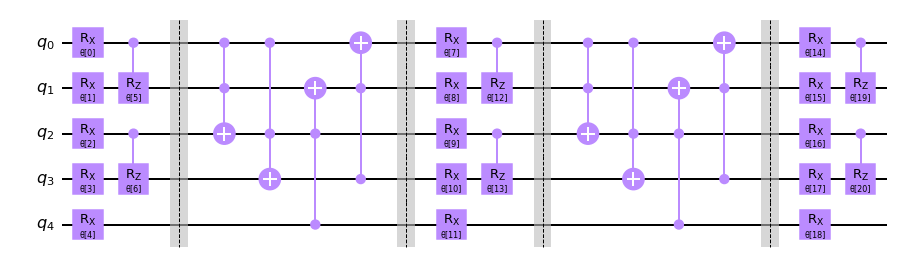

In [1]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter('θ')
qc = NLocal(num_qubits=5, rotation_blocks=[RXGate(theta), CRZGate(theta)], entanglement_blocks=CCXGate(), entanglement=[[0,1,2],[0,2,3],[4,2,1],[3,1,0]], reps=2, insert_barriers=True)
qc.decompose().draw("mpl")

As you can see above, the biggest gate in this case is the Toffoli, that acts on $3$ qubits. That means this circuit is $3$-local.

The most common type of $N$-local circuits are [2-local](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) with single-qubit rotation gates and $2$-qubit entanglement gates. Let's create a $2$-local circuit with Qiskit's [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) class. The syntax is the same as `NLocal`'s but there are some differences. For instance, most gates, like the [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) and [`RZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html) and [`CNOT` (`CX`)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html) can be passed as strings without importing the gates or creating a [`Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) instance.

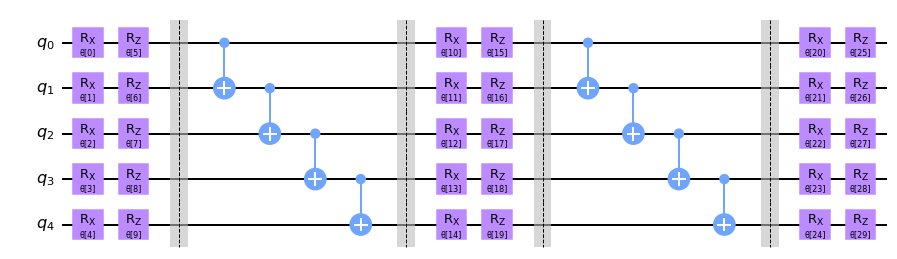

In [2]:
from qiskit.circuit.library import TwoLocal

qc = TwoLocal(num_qubits = 5, rotation_blocks=['rx', 'rz'], entanglement_blocks='cx', entanglement="linear", reps=2, insert_barriers=True)
qc.decompose().draw("mpl")

In this case we used the `linear` entanglement distribution, where each qubit is entangled with the next. For other default strategies, check [the documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html). 

## Problem-specific ansatze

If you have some theoretical knowledge about your problem that helps you restrict your circuit search space to a specific type, you can use it to gain speed without losing accuracy.

### Chemistry-motivated ansatze

For example, in Chemistry the [_Unitary Coupled-Cluster (UCC)_](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.circuit.library.UCC.html#qiskit_nature.second_q.circuit.library.UCC) ansatz is used to solve the electronic structure problem while the [_Unitary Vibrational Coupled-Cluster (UVCC)_](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.circuit.library.UVCC.html#qiskit_nature.second_q.circuit.library.UVCC) ansatz is used to solve the vibrational structure problem.

### Physics-motivated ansatze

An important analog version of quantum computers are quantum annealers. These devices work by preparing quantum states via _adiabatic state preparation_, based on the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem) of quantum mechanics. We can replicate this behavior in quantum computers by digitizing time evolution (e.g. via trotterization) provided that we know the Hamiltonian driving it. For instance, if we are interested in the lowest energy state of our system (i.e. ground state) we can simulate the relaxation of a reference state through parametrized time evolution for the specific Hamiltonian (i.e. energy landscape). This set up is known as the [_Hamiltonian Variational Ansatz (HVA)_](https://arxiv.org/abs/1507.08969), and provides certain theoretical guarantee that the solution state will be achieved.

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright